# Кластеризация

In [1]:
import re
import numpy as np
import pandas as pd
from nltk import word_tokenize
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Предобработка

In [3]:
# Загрузили данные
df_events = pd.read_csv('events.csv')
df_news = pd.read_csv('raw_news.csv', index_col='id')

In [4]:
df_events.head()

,id,date,name
0,1,01/10/17 12:00 AM,Власти Петербурга согласились передать РПЦ Иса...
1,2,01/20/17 12:00 AM,Дональд Трамп вступил в должность президента США.
2,3,02/20/17 12:00 AM,Скоропостижно скончался постпред России при ОО...
3,4,03/02/17 12:00 AM,Вышел фильм Навального «он Вам не димон»
4,5,03/14/17 12:00 AM,CNN показала фильм «Владимир Путин — самый вли...


Посмотрим на данные:

In [5]:
df_news.head(10)

,event_id,text
id,,
0,1,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...
1,1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П..."
2,1,"Аргументы и Факты (aif.ru), Москва, 14 января..."
3,1,"Google Новости ТОП, Москва, 14 января 2017 АК..."
4,1,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО..."
5,1,"Top Real Estate (topre.ru), Москва, 13 января..."
6,1,"Findnews.ru, Москва, 13 января 2017 ПОЛИЦИЯ Н..."
7,1,"ПРАВДА.info (pravda.info), Москва, 13 января ..."
8,1,"Голос Америки (golos-ameriki.ru), Москва, 13 ..."


In [6]:
# Загрузили стопслова для русского языка из nltk
stopset = stopwords.words('russian')
stopset[:10]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [18]:
# Токенизация, чистка
def tokenize(msg):
    # убрали знаки препинания и привели к нижнему регистру
    msg = re.sub('[!"?/\\().:;,-]', '', msg).lower()
    msg = [w for w in word_tokenize(msg) if not w in stopset] # токенизировали и избавились от стоп слов
    return msg

In [13]:
tokenize(df_news['text'].iloc[0], stopset)[:10]

['петербурге',
 'прошел',
 'митинг',
 'против',
 'передачи',
 'исаакиевского',
 'собора',
 'рпц',
 'санктпетербурге',
 'люди']

Посмотрим на распоределение данных по событиям:

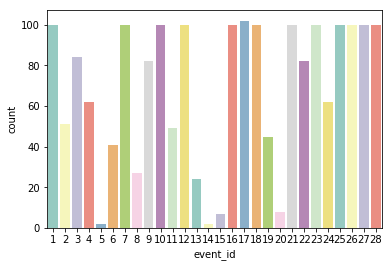

In [15]:
sns.countplot(x=df_news['event_id'], data=df_news, palette="Set3")

Из представленного выше графика видно, что данные неоднородны.

## Часть 2. Кластеризация текстов

**Задание**: Любым известным вам алгоритмом найдите в коллекции новостей 28 кластеров. Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте любые известные вам меры качества для оценки качества кластеризации. Покажите, как $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество кластеризации.

**Задача**: Проверить, получается ли восстановить кластерную структуру новостей, то есть, разделить их на 28 кластеров, соответствущих событиям.

### Строим k-means модель на tf-idf

В этом разделе мы применим один из методов кластеризации с использованием tf-idf и метода k-means.

#### Tf-idf преобразование

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Преобразовываем документы в векторы с tf-idf.

In [19]:
bow_tfidf = TfidfVectorizer(tokenizer=tokenize)
bowed_news = bow_tfidf.fit_transform(df_news['text'])

In [20]:
bowed_news

<1930x65180 sparse matrix of type '<class 'numpy.float64'>'
	with 509127 stored elements in Compressed Sparse Row format>

#### K-means кластериазация

In [21]:
from sklearn.cluster import KMeans

In [22]:
model = KMeans(n_clusters=28, init='k-means++', max_iter=100, n_init=1, random_state=37)
model.fit(bowed_news)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=28, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=37, tol=0.0001, verbose=0)

Чтобы примерно оценить темы новостных кластеров, выведем для каждого из них топ 10 слов, характерных для каждого кластера:

In [23]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = bow_tfidf.get_feature_names()
for i in range(28):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),

Top terms per cluster:
Cluster 0:
 лондоне
 теракт
 теракта
 марта
 мэй
 парламента
 23
 великобритании
 мосту
 террорист
Cluster 1:
 меркель
 германии
 сочи
 украине
 это
 фрау
 путина
 порошенко
 путиным
 украина
Cluster 2:
 вороненков
 вороненкова
 денис
 убит
 госдумы
 дениса
 украины
 киеве
 киева
 убийство
Cluster 3:
 урагана
 москве
 ск
 человек
 петренко
 области
 подмосковье
 стихии
 мая
 московской
Cluster 4:
 акции
 навального
 навальный
 митинг
 протеста
 москве
 митинга
 человек
 тверской
 июня
Cluster 5:
 httpwwwsportexpressruhockeyworldreviewskakizmenitsyasbornayasorlovymikuznecovym1254960
 afp
 кузнецов
 евгений
 игроки
 евтушенко
 любил
 бацын
 фото
 литературы
Cluster 6:
 барселоне
 риа
 барселоны
 новости
 камбрильсе
 испании
 каталонии
 >
 людей
 фургон
Cluster 7:
 собора
 рпц
 исаакиевского
 передачи
 собор
 января
 исаакиевский
 церкви
 акция
 против
Cluster 8:
 %
 d0
 d1
 b5
 be
 b8
 81
 b2
 b0
 80
Cluster 9:
 сбора
 сбор
 курортного
 законопроект
 курортный
 экс

По субъективным ощущениям от характерных терминов, новости кластеризовались хорошо.

### Оценки

In [24]:
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score

In [26]:
labels = df_news.event_id # истинные метки событий
clust_labels = model.labels_ # метки номеров кластеров, возвращённых алгортмом

Суть метрик качества и их значение для модели с дефолтными настройками. В следующем разделе мы попробуем другие модели и пытаемся проинтерпретировать результаты.

Меряем Adjusted Rand Index.

**Rand Index (RI)** выражает схожесть двух разных кластеризаций одной и той же выборки. Пусть n — число объектов в выборке, a — число пар объектов, имеющих одинаковые метки и находящихся в одном кластере, b — число пар объектов, имеющих различные метки и находящихся в разных кластерах.

$$RI = \frac{2(a + b)}{n(n - 1)}$$

Это доля объектов, для которых эти разбиения (исходное и полученное в результате кластеризации) "согласованы". Эта мера не зависит от значений и перестановок меток. 

**Adjusted Rand Index** — это Rand Index, нормированный, чтобы он давал значения близкие к нулю для случайных кластеризаций при любом n и числе кластеров:

$$ARI = \frac{RI - E[RI]}{max(RI)-E[RI]}$$

(Теория взята из статьи на хабрахабр: https://habrahabr.ru/company/ods/blog/325654/)

In [27]:
print("Adjusted Rand-Index:",  adjusted_rand_score(labels, clust_labels))

Adjusted Rand-Index: 0.766098680977905


Меряем гомогенность, полноту и V-меру.

Пусть K — результат кластеризации, C — истинное разбиение выборки на классы. Гомогенность h и полнота с определяются с использованием функций энтропии и условной энтропии:

$$h = 1 - \frac{H(C|K)}{H(C)}\text{, }c = 1 - \frac{H(K|C)}{H(K)}$$

V-мера -- это среднее гармоическое от h и c.

Так как данные метрики дают более точный результат при маленьком количестве кластеров, мы будем в большей мере ориентироваться на ARI.
(Теория взята из статьи на хабрахабр: https://habrahabr.ru/company/ods/blog/325654/)

In [28]:
print("Гомогенность:", homogeneity_score(labels, clust_labels))
print("Полнота:", completeness_score(labels, clust_labels))
print("V-мера",  v_measure_score(labels, clust_labels))

Гомогенность: 0.8982108664656662
Полнота: 0.9080279150963403
V-мера 0.9030927125685762


Как мы видим, новости довольно хорошо разбиваются на кластеры в конфигурации tf-idf + k-means.

### Альтернативные модели

А теперь давайте поизменяем гиперпараметры и попробуем другие алгоритмы. Станет ли лучше?

# SVD

Возмём задачу из позапрошлого семинара и добавим в представлние дркументов SVD. 

In [29]:
lenta = pd.read_csv('news_lenta_cropped.csv')

In [31]:
lenta.head()

,title,topic
0,Грудь Бритни Спирс вновь выскочила из лифчика ...,Культура
1,Попытка вернуть укатившийся мяч у Кремлевской ...,Силовые структуры
2,Хабенский стал врагом Украины,Культура
3,В Туркмении запретили продажу алкоголя,Бывший СССР
4,В Великобритании нашли утерянный сценарий Стен...,Культура


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [38]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(lenta.title)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(bow, lenta.topic)

In [43]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
from sklearn.metrics import classification_report

In [45]:
print(classification_report(y_test, clf.predict(X_test)))

                   precision    recall  f1-score   support

      Бывший СССР       0.96      0.96      0.96     12949
         Культура       0.93      0.97      0.95     13162
Силовые структуры       0.93      0.87      0.90      4644
         Ценности       0.96      0.75      0.84      1728

      avg / total       0.94      0.94      0.94     32483



Попробуем SVD:

In [46]:
from sklearn.decomposition import TruncatedSVD

In [76]:
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)

In [77]:
svd.fit(bow)

TruncatedSVD(algorithm='randomized', n_components=300, n_iter=7,
       random_state=42, tol=0.0)

In [78]:
bow_transformed = svd.transform(bow)

In [79]:
len(bow_transformed[0])

300

Посмотрим, что он умеет:

In [102]:
a = svd.transform(vectorizer.transform(['президент приехал с визитом']))
b = svd.transform(vectorizer.transform(['президент приехал в москву']))
c = svd.transform(vectorizer.transform(['кот смотрит на картины']))

In [103]:
from sklearn.metrics.pairwise import cosine_similarity

In [104]:
cosine_similarity(a, b)

array([[0.72361874]])

In [105]:
cosine_similarity(a, c)

array([[-0.00037305]])

In [80]:
X_train, X_test, y_train, y_test = train_test_split(bow_transformed, lenta.topic)

In [82]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [83]:
print(classification_report(y_test, clf.predict(X_test)))

                   precision    recall  f1-score   support

      Бывший СССР       0.87      0.84      0.86     12940
         Культура       0.77      0.92      0.84     13188
Силовые структуры       0.76      0.58      0.66      4618
         Ценности       0.78      0.32      0.46      1737

      avg / total       0.81      0.81      0.80     32483



**Задание**: попробуйте разное количество компонент в SVD.